In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
    # import pytorch3d
# except ModuleNotFoundError:
    # need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
import os
import torch
from torch import nn

from pytorch3d.datasets import ShapeNetCore
import matplotlib.pyplot as plt
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    NormalSoftPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    tbn_matrices,
)
from torchvision.transforms import RandomAffine
from pytorch3d.renderer.mesh import tbn_matrices
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [4]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [5]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [6]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [7]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# # Set paths
# DATA_DIR = "./data"
# obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# # obj_filename = os.path.join(DATA_DIR, "cube_mesh/six_colour_cube.obj")


# # Load obj file
# mesh = load_objs_as_meshes([obj_filename], device=device)

# # We scale normalize and center the target mesh to fit in a sphere of radius 1 
# # centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# # to its original center and scale.  Note that normalizing the target mesh, 
# # speeds up the optimization but is not necessary!
# verts = mesh.verts_packed()
# N = verts.shape[0]
# center = verts.mean(0)
# scale = max((verts - center).abs().max(0)[0])
# mesh.offset_verts_(-center)
# mesh.scale_verts_((0.75 / float(scale)));

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


In [8]:
from pyperlin import FractalPerlin2D

random_seed = 10
np.random.seed(random_seed)

# Functions from my L4 project
def to_geocentric(lat, lon):
    """
    Converts a latitude longitude pair to geocentric X Y Z coordinates
    """
    lat = np.radians(lat)
    lon = np.radians(lon)
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])


def train_test_split(list):
    return list[:len(list)//2], list[len(list)//2:]

# lat lon but longitude is scaled to half to have a square representation
def to_lat_lon(coords):
    """
    Converts X Y Z geocentric coordinates into latitude and longitude
    """
    return np.array([np.degrees(np.arcsin(coords[2])), np.degrees(np.arctan2(coords[1], coords[0]))])

def generate_perlin_texture(generator):
    texture = torch.ones(texture_size)*0.25
    for i in range(3):
        resolutions = [(2**i,2**i) for i in range(1,7)] #for lacunarity = 2.0
        factors = [.9**i for i in range(6)] #for persistence = 0.5
        channel = FractalPerlin2D(texture_size[:-1], resolutions, factors, generator=generator)().cpu().numpy()
        texture[...,i] += channel * 0.5
    return texture

def generate_normal_map(generator, texture_size):
    zero_dims = [1, texture_size[1], texture_size[1], 2]
    ones_dims = [1, texture_size[1], texture_size[1], 1]
    normal_map_flat = torch.cat([torch.ones(zero_dims)*0.5, torch.ones(ones_dims)], dim=3)
    return normal_map_flat*0.75 + generate_perlin_texture(generator) *0.25

def load_shapenet_mesh(texture_size, gen, shapenet_dataset, seed):
    texture = generate_perlin_texture(gen) * 0.5 + torch.ones(texture_size) * 0.5
    # Generate random normal maps using perlin noise/trig functions
    normal_map = generate_normal_map(gen, texture_size)
    while True:
        try:
            shapenet_model = np.random.choice(shapenet_dataset)
            break
        except IsADirectoryError:
            continue
    model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

    # Create UVs assuming equirectangular projection of sphere (very much approximation)
    xyz_to_u = torch.rad2deg(torch.arcsin(model_verts[:,2])) + 90
    xyz_to_u = xyz_to_u - torch.min(xyz_to_u)
    xyz_to_u = xyz_to_u / torch.max(xyz_to_u)

    xyz_to_v = (torch.rad2deg(torch.atan2(model_verts[:,1], model_verts[:,0])) + 180) / 2 
    xyz_to_v = xyz_to_v / torch.max(xyz_to_v)
    xyz_to_v = xyz_to_v - torch.min(xyz_to_v)
    sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1)

    model_textures = TexturesUV(texture, model_faces.unsqueeze(0), sphere_verts_uvs.unsqueeze(0))
    model_normalmaps = TexturesUV(normal_map, model_faces.unsqueeze(0), sphere_verts_uvs.unsqueeze(0))

    shapenet_model_mesh = Meshes(
        verts=[model_verts.to(device)],   
        faces=[model_faces.to(device)],
        textures=model_textures.to(device),
        normalmaps=model_normalmaps.to(device),
    )
    # Scale mesh to be normalized
    center = model_verts.mean(0)
    scale = max((model_verts - center).abs().max(0)[0])
    shapenet_model_mesh.offset_verts_(-center.to(device))
    shapenet_model_mesh.scale_verts_((0.75 / float(scale.to(device))))

    mesh_dict = {"mesh":shapenet_model_mesh, "synset_id":shapenet_model["synset_id"], "model_id":shapenet_model["model_id"]}
    return mesh_dict

In [9]:
# imsize = 256
# # lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
# lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# # We arbitrarily choose one particular view that will be used to visualize 
# # results
# # Changed to novel view
# rand_elev = 45
# rand_azim = 135
# R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

# camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
#                                   T=T_novel) 


# # camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
# #                                   T=T[None, 1, ...]) 

# # Define the settings for rasterization and shading. Here we set the output 
# # image to be of size 128X128. As we are rendering images for visualization 
# # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# # rasterize_meshes.py for explanations of these parameters.  We also leave 
# # bin_size and max_faces_per_bin to their default values of None, which sets 
# # their values using heuristics and ensures that the faster coarse-to-fine 
# # rasterization method is used.  Refer to docs/notes/renderer.md for an 
# # explanation of the difference between naive and coarse-to-fine rasterization. 
# raster_settings = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=0.0, 
#     faces_per_pixel=1, 
#     perspective_correct=False,
# )

# # Create a Phong renderer by composing a rasterizer and a shader. The textured 
# # Phong shader will interpolate the texture uv coordinates for each vertex, 
# # sample from a texture image and apply the Phong lighting model
# mesh_to_render = meshes[0]
# TBN_matrices = tbn_matrices(mesh_to_render)
# renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings
#     ),
#     shader=NormalSoftPhongShader(
#         device=device, 
#         cameras=camera,
#         lights=lights,
#         tangent_matrices=TBN_matrices,
#     )
# )
# with torch.no_grad():
#     random_target = renderer(mesh_to_render, cameras=camera, lights=lights)[...,:3]
# plt.imshow(random_target.cpu().numpy()[0])

In [10]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib


# texturesuv_image_matplotlib(mesh_to_render.normalmaps, subsample=None)

# # print(texture_image.shape)
# # plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

In [11]:
# the number of different viewpoints from which we want to render the mesh.
def generate_training_data(R, T, TBN_matrices, target_mesh, imsize):
    with torch.no_grad():
        batch_views = 1
        np.random.seed(random_seed)

        num_views = len(R)

        rand_elev = 45
        rand_azim = 135
        R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

        camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )

        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=camera,
                lights=lights,
                tangent_matrices=TBN_matrices,
            )
        )

        # for i
        # Create a batch of meshes by repeating the cow mesh and associated textures. 
        # Meshes has a useful `extend` method which allows us do this very easily. 
        # This also extends the textures. 
        meshes = target_mesh.extend(batch_views)
        target_rgb = []
        target_cameras = []
        # Render small batches of target views on GPU and append to list to be later converted to CPU tensor
        for i in range(num_views // batch_views):
            # Create cameras for rendering the batch
            cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
            # Render the cow mesh from each viewing angle
            target_images_batch = renderer(meshes, cameras=cameras, lights=lights)

            # Our multi-view cow dataset will be represented by these 2 lists of tensors,
            # each of length num_views.
            target_rgb_batch = [target_images_batch[i, ..., :3].cpu() for i in range(batch_views)]
            target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                                T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
            target_rgb.extend(target_rgb_batch)
            target_cameras.extend(target_cameras_batch)


        # 50/50 split of views for train/test
        target_rgb, test_rgb = train_test_split(target_rgb)
        target_cameras, test_cameras = train_test_split(target_cameras)
        random_target = renderer(target_mesh, cameras=camera, lights=lights)[...,:3]
        return target_rgb, test_rgb, random_target, target_cameras, test_cameras, camera

Visualize the dataset:

In [12]:
# # RGB images
# print()
# image_grid(np.asarray(target_rgb[:10]), rows=4, cols=5, rgb=True)
# plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

In [13]:
# # Rasterization settings for silhouette rendering  
# sigma = 1e-4
# raster_settings_silhouette = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
#     faces_per_pixel=50, 
#     perspective_correct=False,
# )

# # Silhouette renderer 
# renderer_silhouette = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings_silhouette
#     ),
#     shader=SoftSilhouetteShader()
# )

# # # Render silhouette images.  The 3rd channel of the rendering output is 
# # # the alpha/silhouette channel
# # silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
# # print(silhouette_images.shape)
# # target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# # # Visualize silhouette images
# # image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
# # plt.show()

In [14]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh

def visualize_prediction(predicted_mesh, fig_path, renderer, iters, 
                         target_image, title='', 
                         silhouette=False, camera=None):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.squeeze().cpu().detach().numpy())
    plt.title(f"Mesh at iteration {iters:d} vs. target")
    plt.axis("off")
    if silhouette:
        plt.savefig(os.path.join(fig_path, f"silhouette_prediction_{iters:d}.png"), bbox_inches="tight")
    else:
        plt.savefig(os.path.join(fig_path, f"prediction_{iters:d}.png"), bbox_inches="tight")


def save_maps(mesh, fig_path, iters):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    plt.imshow(mesh.textures.maps_padded().cpu().detach().squeeze())
    plt.axis("off");
    plt.savefig(os.path.join(fig_path, f"texture_{iters:d}.png"), bbox_inches="tight")
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    plt.imshow(mesh.normalmaps.maps_padded().cpu().detach().squeeze())
    plt.axis("off");
    plt.savefig(os.path.join(fig_path, f"normalmap_{iters:d}.png"), bbox_inches="tight")

# Plot losses as a function of optimization iteration
def plot_losses(losses, fig_path):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")
    plt.savefig(os.path.join(fig_path, "losses.png"), bbox_inches="tight")


In [15]:
# Functions from my L4 project
def to_geocentric(lat, lon):
    """
    Converts a latitude longitude pair to geocentric X Y Z coordinates
    """
    lat = np.radians(lat)
    lon = np.radians(lon)
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])

# lat lon but longitude is scaled to half to have a square representation
def to_lat_lon(coords):
    """
    Converts X Y Z geocentric coordinates into latitude and longitude
    """
    return np.array([np.degrees(np.arcsin(coords[2])), np.degrees(np.arctan2(coords[1], coords[0]))])

# Creating UVs for sphere using equirectangular projection with scaled v axis
def generate_spherical_uvs(target_mesh):
    sphere_verts = target_mesh.verts_packed()
    xyz_to_u = torch.rad2deg(torch.arcsin(sphere_verts[:,2])) + 90
    xyz_to_v = (torch.rad2deg(torch.atan2(sphere_verts[:,1], sphere_verts[:,0])) + 180) / 2 
    print(xyz_to_u.shape, xyz_to_v.shape)
    sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1) / 180
    print(sphere_verts_uvs.shape, sphere_verts_uvs.max(), sphere_verts_uvs.min())
    # need to solve seams somehow
    # u = 0.5 + (torch.atan2(verts[:,0], verts[:,1])/(np.pi*2))
    # v = 0.5 - (torch.arcsin(verts[:,2])/np.pi)
    # uv_map = torch.stack([u,v], dim=1).unsqueeze(dim=0).to(device)
    print("Target shapes faces: {}, verts: {}".format(mesh.faces_padded().shape, mesh.verts_padded().shape, ))
    print("Target shapes facesUVs: {}, vertsUVs: {}".format(mesh.textures.faces_uvs_padded().shape,  mesh.textures.verts_uvs_padded().shape))
    print(target_mesh.verts_packed().shape)
    # target_mesh.verts_padded().map
    plt.scatter(sphere_verts_uvs.cpu()[:,0], sphere_verts_uvs.cpu()[:,1], s=1)
    plt.show()
    target_mesh.textures = TexturesUV(mesh.textures.maps_padded(), faces_uvs=target_mesh.faces_packed().unsqueeze(0), verts_uvs=sphere_verts_uvs.unsqueeze(0))


def generate_silhouette_training_data(target_mesh, R,T, batch_views=1):
    with torch.no_grad():
        R, _ = train_test_split(R)
        T, _ = train_test_split(T)
        num_views = len(R)
        # Rasterization settings for silhouette rendering  
        sigma = 1e-4
        raster_settings_silhouette = RasterizationSettings(
            image_size=imsize, 
            blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
            faces_per_pixel=50, 
            perspective_correct=False,
        )

        # Silhouette renderer 
        renderer_silhouette = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings_silhouette
            ),
            shader=SoftSilhouetteShader()
        )

        # Render silhouette images.  The 3rd channel of the rendering output is 
        # the alpha/silhouette channel
        target_cameras = []
        target_silhouette = []
        silhouette_images = []
        for i in range(num_views // batch_views):
            # Create cameras for rendering the batch
            cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
            # Render the cow mesh from each viewing angle
            silhouette_images_batch = renderer_silhouette(target_mesh, cameras=cameras, lights=lights)
            silhouette_images.extend(silhouette_images_batch.cpu())
            # Our multi-view cow dataset will be represented by these 2 lists of tensors,
            # each of length num_views.
            target_silhouette_batch = [silhouette_images_batch[i, ..., 3].cpu() for i in range(batch_views)]
            # target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                                #    T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
            target_silhouette.extend(target_silhouette_batch)
            target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
            target_cameras.extend(target_cameras_batch)
        # Visualize silhouette images
        # print(np.asarray(target_silhouette[:10])[0].shape)
        # image_grid(np.asarray(silhouette_images[:10]), rows=4, cols=5, rgb=False)
        # plt.show()
        return target_silhouette, target_cameras

In [16]:
def mesh_prediction(target_mesh, R, T, fig_path, batch_views = 1):
    print("Generating dataset", end="\r")
    target_silhouette, target_cameras = generate_silhouette_training_data(target_mesh, R,T)
    print("Generating dataset done")
    # Rasterization settings for differentiable rendering, where the blur_radius
    # initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
    # Renderer for Image-based 3D Reasoning', ICCV 2019
    sigma = 1e-4
    raster_settings_soft = RasterizationSettings(
        image_size=imsize, 
        blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
        faces_per_pixel=50, 
        perspective_correct=False,
    )

    # Silhouette renderer 
    renderer_silhouette = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=camera, 
            raster_settings=raster_settings_soft
        ),
        shader=SoftSilhouetteShader()
    )

    # We initialize the source shape to be a sphere of radius 1.  
    silhouette_src_mesh = ico_sphere(4, device)
    # src_mesh = mesh.clone()
    # Number of views to optimize over in each SGD iteration
    num_views_per_iteration = 5
    # Number of optimization steps
    Niter = 1000
    # Plot period for the losses
    plot_period = 250

    # %matplotlib inline

    # Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
    # consistency, and mesh laplacian smoothing
    losses = {"silhouette": {"weight": 1.0, "values": []},
            "edge": {"weight": 1.0, "values": []},
            "normal": {"weight": 0.01, "values": []},
            "laplacian": {"weight": 1.0, "values": []},
            }

    # Losses to smooth / regularize the mesh shape
    def update_mesh_shape_prior_losses(mesh, loss):
        # and (b) the edge length of the predicted mesh
        loss["edge"] = mesh_edge_loss(mesh)
        
        # mesh normal consistency
        loss["normal"] = mesh_normal_consistency(mesh)
        
        # mesh laplacian smoothing
        loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

    # We will learn to deform the source mesh by offsetting its vertices
    # The shape of the deform parameters is equal to the total number of vertices in
    # src_mesh
    verts_shape = silhouette_src_mesh.verts_packed().shape
    deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

    # The optimizer
    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
    loop = tqdm(range(Niter))

    for i in loop:
        # Initialize optimizer
        optimizer.zero_grad()
        
        # Deform the mesh
        new_src_mesh = silhouette_src_mesh.offset_verts(deform_verts)
        
        # Losses to smooth /regularize the mesh shape
        loss = {k: torch.tensor(0.0, device=device) for k in losses}
        update_mesh_shape_prior_losses(new_src_mesh, loss)
        
        # Compute the average silhouette loss over two random views, as the average 
        # squared L2 distance between the predicted silhouette and the target 
        # silhouette from our dataset
        for j in np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]:
            images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
            predicted_silhouette = images_predicted[..., 3]
            loss_silhouette = ((predicted_silhouette - target_silhouette[j].to(device)) ** 2).mean()
            loss["silhouette"] += loss_silhouette / num_views_per_iteration
        
        # Weighted sum of the losses
        sum_loss = torch.tensor(0.0, device=device)
        for k, l in loss.items():
            sum_loss += l * losses[k]["weight"]
            losses[k]["values"].append(float(l.detach().cpu()))

        
        # Print the losses
        loop.set_description("total_loss = %.6f" % sum_loss)
        
        # Plot mesh
        if i % plot_period == 0:
            visualize_prediction(new_src_mesh, fig_path, renderer=renderer_silhouette, iters=i, title="iter: %d" % i, silhouette=True,
                                target_image=target_silhouette[0], camera=target_cameras[0])
            
        # Optimization step
        sum_loss.backward()
        optimizer.step()
    
    silhouette_result = new_src_mesh.clone().detach()
    return silhouette_result

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [17]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# # texture_image=src_mesh.textures.maps_padded()
# texturesuv_image_matplotlib(silhouette_src_mesh.textures, subsample=None)

# # print(texture_image.shape)
# # plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [18]:
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler
        self.weight = torch.nn.Parameter(deconv.weight)

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class UnsqueezeLatent(nn.Module):
    layer = 0
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        return torch.unsqueeze(torch.unsqueeze(inputs, 2), 3)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.05)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.05)
        nn.init.constant_(m.bias.data, 0)



# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, ngf = 32, nc=3, nz=100, type = "normal"):
        super(Generator, self).__init__()
        self.type = type
        self.ngpu = ngpu
        self.deconv = nn.Sequential(
            # Testing convoluting target image first 
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Flatten(),
            nn.Linear(ngf * 4 * 16*16, nz),
            UnsqueezeLatent(),
        )
        self.tanh = nn.Tanh()           
        self.upsampler = nn.Upsample(scale_factor=8, mode='bilinear')
        self.normal_generator = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
        )
        self.texture_generator = nn.Sequential(
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
        )

        if type == "normal":
            self.generator = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                # nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf) x 32 x 32
                # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf//2),
                # nn.ReLU(True),
                # nn.Dropout2d(),
                # state size. (ngf) x 64 x 64
                nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
                nn.Tanh(),
                # nn.Upsample(scale_factor=4, mode='bilinear')
                # state size. (nc) x 128 x 128
            )
        elif type == "residual":
            self.generator =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*8) x 4 x 4
            ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*4) x 8 x 8
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*2) x 16 x 16
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf//2),
            # nn.ReLU(True),
            # nn.Dropout2d(),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh(),
            # nn.Upsample(scale_factor=4, mode='bilinear')
            # state size. (nc) x 128 x 128
        )
        elif type == "simultaneous":
            self.generator = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                # nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf) x 32 x 32
                # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf//2),
                # nn.ReLU(True),
                # nn.Dropout2d(),
                # state size. (ngf) x 64 x 64
                # nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
                # nn.Upsample(scale_factor=4, mode='bilinear')
                # state size. (nc) x 128 x 128
            )

    def forward(self, input):
        if self.type == "simultaneous":
            result = self.generator(input)
            return self.upsampler(self.tanh(self.texture_generator(result))), self.upsampler(self.tanh(self.normal_generator(result)))
        else: 
            return self.generator(input)



In [19]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, ndf):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            # state size. (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
def map_prediction(target_mesh, starting_mesh, fig_path, R, T):
    print("Generating dataset", end="\r")
    TBN_matrices = tbn_matrices(target_mesh)
    target_rgb, test_rgb, random_target, target_cameras, test_cameras, camera = generate_training_data(R, T, TBN_matrices, target_mesh, imsize)
    print("Generating dataset done")

    # Rasterization settings for differentiable rendering, where the blur_radius
    # initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
    # Renderer for Image-based 3D Reasoning', ICCV 2019

    sigma = 1e-4
    raster_settings_soft = RasterizationSettings(
        image_size=imsize, 
        blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
        faces_per_pixel=50, 
        perspective_correct=False,
    )

    new_TBN_matrices = tbn_matrices(starting_mesh)
    # Differentiable soft renderer using per vertex RGB colors for texture
    renderer_textured = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=camera, 
            raster_settings=raster_settings_soft
        ),
        shader=NormalSoftPhongShader(device=device, 
            cameras=camera,
            lights=lights,
            tangent_matrices=new_TBN_matrices)
    )

    map_losses = {
            "rgb": {"weight": 1.0, "values": []},
            # "adversarial": {"weight": 0.01, "values": []},
            "smoothness":{"weight":0.1, "values": []},
            "normal_smoothness":{"weight":0.1, "values": []}
            }
    losses_gan = {
            "generator": {"weight": 1.0, "values": []},
            "discriminator":{"weight":1.0, "values": []}

    }

    faces_uvs = starting_mesh.textures.faces_uvs_padded()
    uv_map = starting_mesh.textures.verts_uvs_padded()

    # Number of views to optimize over in each SGD iteration
    num_views_per_iteration = min(2, num_views)
    # Number of optimization steps
    Niter = 2000
    # Plot period for the losses
    plot_period = Niter // 5

    loop = tqdm(range(Niter))
    # maps = [sphere_verts_rgb.detach().cpu()]


    # Adversarial loss from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    nc = 3
    ndf = 32
    ngf = 32
    nz = 100

    # Create discriminator for adversarial loss
    ngpu = 1
    workers = 2
    lr = 0.001
    beta1 = 0.3
    bce_loss = nn.BCELoss()
    # netD = Discriminator(ngpu).to(device)
    # netD.apply(weights_init)
    # real_label = 1.
    # fake_label = 0.
    # optimizerD = torch.optim.SGD(netD.parameters(), lr=lr)


    # Create the generator
    netG = Generator(ngpu, ngf, nc, nz, "simultaneous").to(device)
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    netG.apply(weights_init)

    # Need to create UV map for the sphere and optimize that together with the texture
    # The optimizer
    # maps_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces_uvs, verts_uvs=uv_map)

    # Need to create UV map for the sphere and optimize that together with the texture
    scale_factor = 1
    texture_size = list(target_mesh.textures.maps_padded().shape)
    texture_size[1] //= scale_factor
    texture_size[2] //= scale_factor

    print("Texture Size: {}".format(texture_size))
    # sphere_verts_rgb = torch.zeros(texture_size, device=device, requires_grad=True)
    # optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)

    # sphere_verts_rgb = src_mesh.textures.maps_padded()
    # sphere_verts_rgb.requires_grad = True
    # The optimizer
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5
    # print(random_vector.shape)
    # sphere_verts_rgb = netG(target_rgb[0].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1)
    sphere_verts_rgb, normal_map_base = netG(random_vector)
    zero_dims = texture_size[:3]
    zero_dims.append(2)
    ones_dims = texture_size[:3]
    ones_dims.append(1)
    # begin with a flat normal map and just offset it using the generator by a small amount
    normal_map_flat = torch.cat([torch.ones(zero_dims).to(device)*0.5, torch.ones(ones_dims).to(device)], dim=3)
    # normal_map_base.requires_grad = True
    # optimizerNorm = torch.optim.Adam([normal_map_base], lr=lr, betas=(beta1, 0.999))


    maps_src_mesh = starting_mesh
    maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
    maps_src_mesh.normalmaps = TexturesUV(normal_map_flat, faces_uvs=faces_uvs, verts_uvs=uv_map)
    # print(maps_src_mesh.normalmaps.maps_padded().shape)

    # Cosine similarity loss for normal map
    cos_similarity = torch.nn.CosineSimilarity(dim=3)


    # period to evaluate mesh against test views with normal rasterization
    eval_period = 20
    mse_iters = []

    for i in loop:
        transform_range_horizontal = 5/sphere_verts_rgb.shape[2]
        transform_range_vertical = 5/sphere_verts_rgb.shape[3]
        transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
        # Initialize optimizer
        optimizerG.zero_grad()
        
        # Deform the mesh
        # maps_src_mesh = src_mesh.offset_verts(deform_verts)
        
        # Add per vertex colors to texture the mesh
        # TODO create UV map for faces and vertices for the default sphere

        # sphere_verts_rgb = netG(target_rgb[i % len(target_rgb)].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) #- for generator network
        sphere_verts_rgb, normal_map_base = netG(random_vector)
        maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
        new_normal_map = normal_map_base.permute(0,2,3,1) * 0.25 + normal_map_flat * 0.75
        # new_normal_map = normal_map_flat
        maps_src_mesh.normalmaps = TexturesUV(new_normal_map, faces_uvs=faces_uvs, verts_uvs=uv_map)

        # Losses to smooth /regularize the mesh shape
        map_loss = {k: torch.tensor(0.0, device=device) for k in map_losses}
        # update_mesh_shape_prior_losses(maps_src_mesh, loss)
        # loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        rendered_rgb = []

        # Getting examples from renderer as the Generator
        random_views = np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]
        for j in random_views:
            images_predicted = renderer_textured(maps_src_mesh, cameras=target_cameras[j], lights=lights)

            
            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = images_predicted[..., :3]
            rendered_rgb.append(predicted_rgb.squeeze())
            loss_rgb = ((predicted_rgb - target_rgb[j].to(device)) ** 2).mean()

            # Shifted image to get the image to be smoother/gradient between pixels to be smoother
            smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb))**2).mean()
            normal_smoothness = torch.abs(cos_similarity(maps_src_mesh.normalmaps.maps_padded(), transform(maps_src_mesh.normalmaps.maps_padded())).mean())
            # print(normal_smoothness)

            map_loss["rgb"] += loss_rgb / num_views_per_iteration
            map_loss["smoothness"] += smoothness / num_views_per_iteration
            map_loss["normal_smoothness"] += normal_smoothness / num_views_per_iteration

        # Weighted sum of the losses
        map_sum_loss = torch.tensor(0.0, device=device)
        for k, l in map_loss.items():
            map_sum_loss += l * map_losses[k]["weight"]
            map_losses[k]["values"].append(float(l.detach().cpu()))
        loop.set_description("total_loss = %.6f" % map_sum_loss)


        # for k, l in loss_gan.items():
            # losses_gan[k]["values"].append(float(l.detach().cpu()))
        # Print the losses
        
        # Plot mesh
        if i % plot_period == 0:
            visualize_prediction(maps_src_mesh, fig_path=fig_path, renderer=renderer_textured, iters=i, title="iter: %d" % i, silhouette=False, camera=camera, target_image=random_target)
            save_maps(maps_src_mesh, fig_path, i)
            # maps.append(sphere_verts_rgb.detach().cpu())

        # Optimization step
        map_sum_loss.backward()
        optimizerG.step()

        
        if i % eval_period == 0:
            mse_iters.append(evaluate_model(maps_src_mesh, new_TBN_matrices, test_cameras, test_rgb))

    fig = plt.figure(figsize=(13, 5))
    plt.plot(torch.arange(0, Niter, 20)[1:], torch.tensor(mse_iters[1:]).cpu())
    plt.xlabel("Iterations")
    plt.ylabel("MSE on test views")
    plt.savefig(os.path.join(fig_path, "test_MSE.png"), bbox_inches="tight")



In [21]:
def evaluate_model(eval_mesh, TBN_matrices, test_cameras, test_rgb):
    with torch.no_grad():
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )

        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=test_cameras,
                lights=lights,
                tangent_matrices=TBN_matrices,
            )
        )

        image_MSE = 0
        # Calculate RGB loss for each view point in test set
        for j in range(len(test_cameras)):
            image_predicted = renderer(eval_mesh, cameras=test_cameras[j], lights=lights,)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = image_predicted[..., :3]
            predicted_rgb.squeeze()
            image_MSE += ((predicted_rgb - test_rgb[j].to(device)) ** 2).mean()
        mean_MSE = image_MSE / len(test_cameras)
        # visualize_prediction(eval_mesh, renderer=renderer, camera=test_cameras[1], silhouette=False,target_image = test_rgb[1])

        return mean_MSE
    # print(mean_MSE)

# print(evaluate_model())

/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/datasets/shapenet/shapenet_core.py:114: UserWarning: The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location ./data/ShapeNetsamples: 04225987, 03593526, 03691459, 03928116, 04379243, 03636649, 03337140, 02801938, 03624134, 02871439, 02954340, 03761084, 03046257, 03759954, 02933112, 02876657, 02958343, 04330267, 04004475, 03642806, 02992529, 04554684, 03948459, 02942699, 03085013, 02808440, 02924116, 04090263, 04530566, 04074963, 03261776, 02828884, 03211117, 03467517, 03325088, 03513137, 03991062, 04401088, 04256520, 03797390, 02880940, 04099429, 03710193, 02946921, 04468005, 03001627, 02691156, 03207941, 03790512, 02818832, 02773838, 02747177, 02843684, 03938244
  warnings.warn(msg)


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/io/mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


Finished generating meshes
Predicting mesh


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


Generating dataset done


  0%|          | 0/1000 [00:00<?, ?it/s]

Predicting mesh maps
Generating dataset done


  0%|          | 0/2000 [00:00<?, ?it/s]

Texture Size: [1, 1024, 1024, 3]


/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

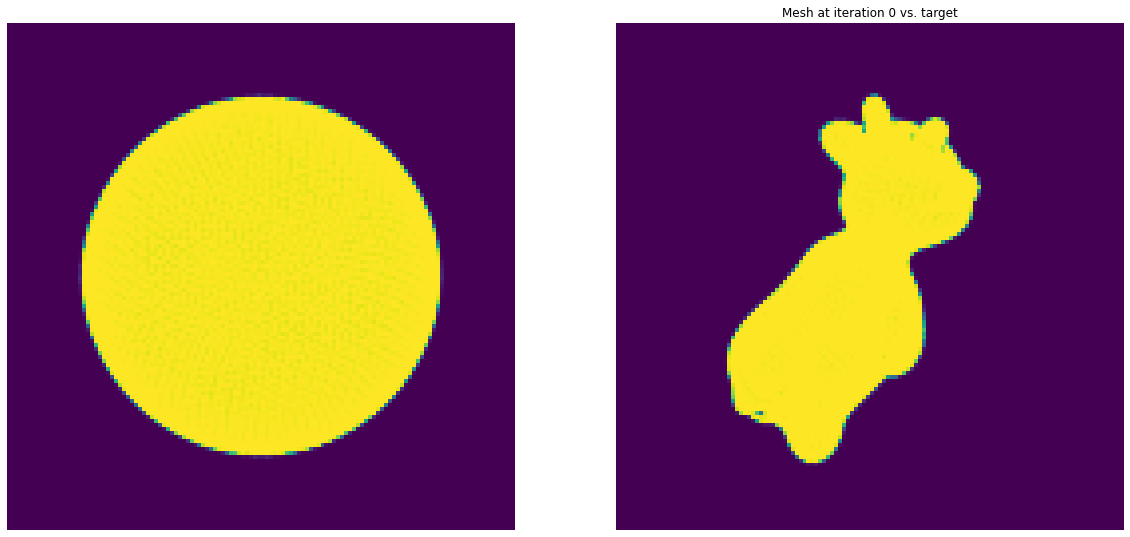

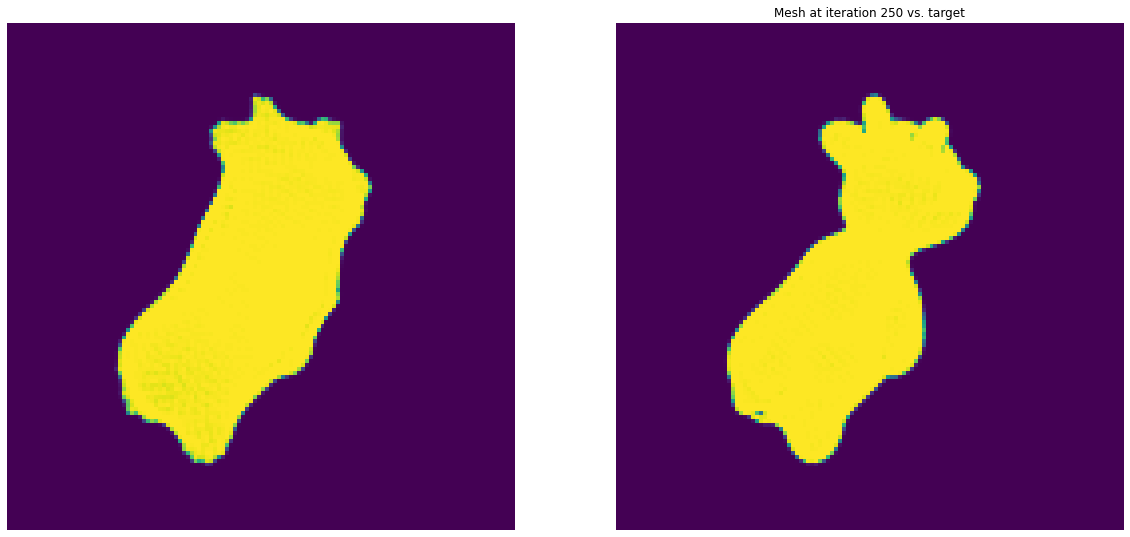

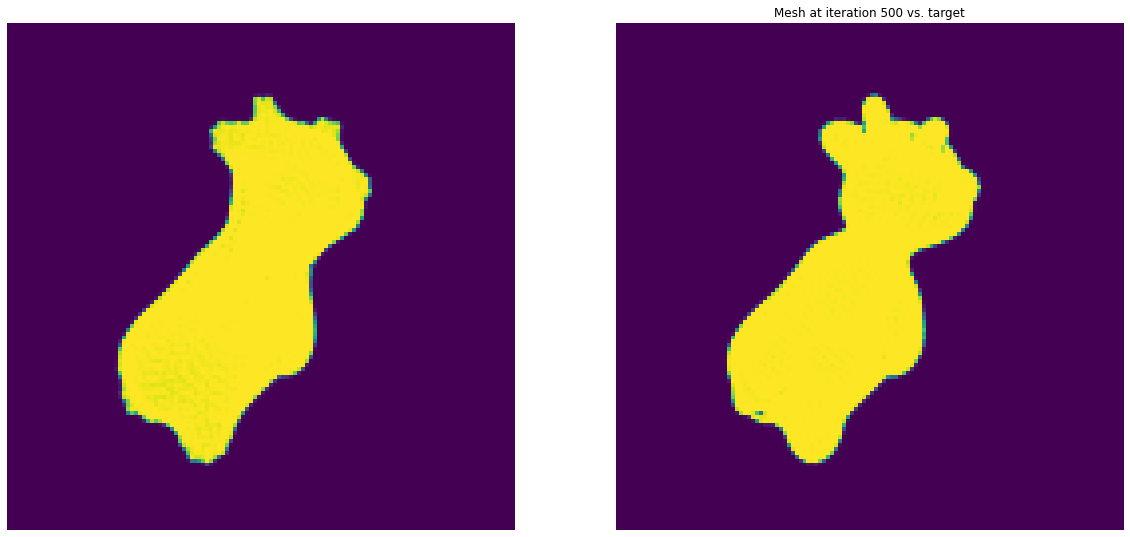

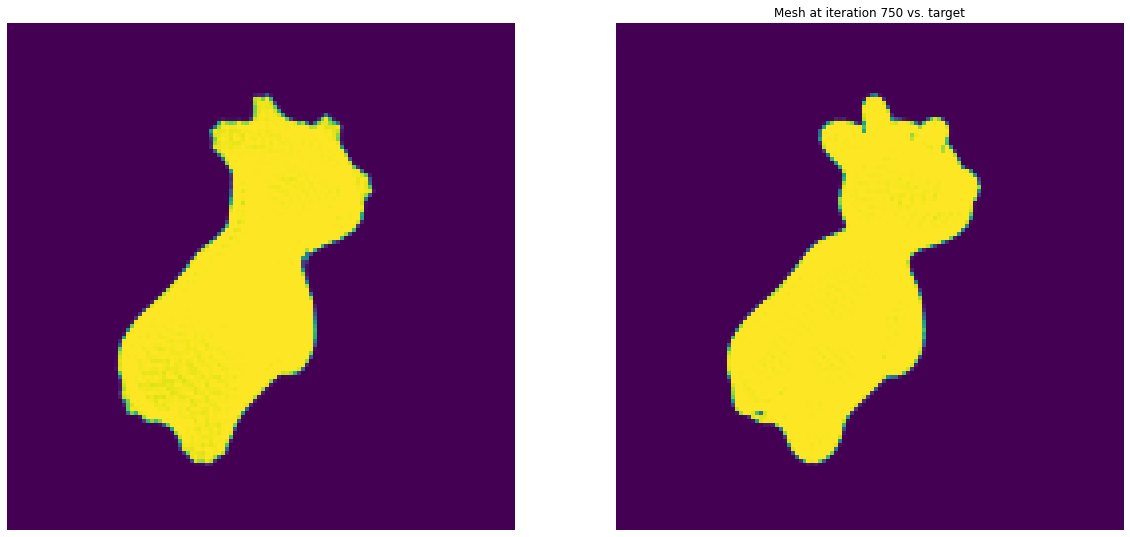

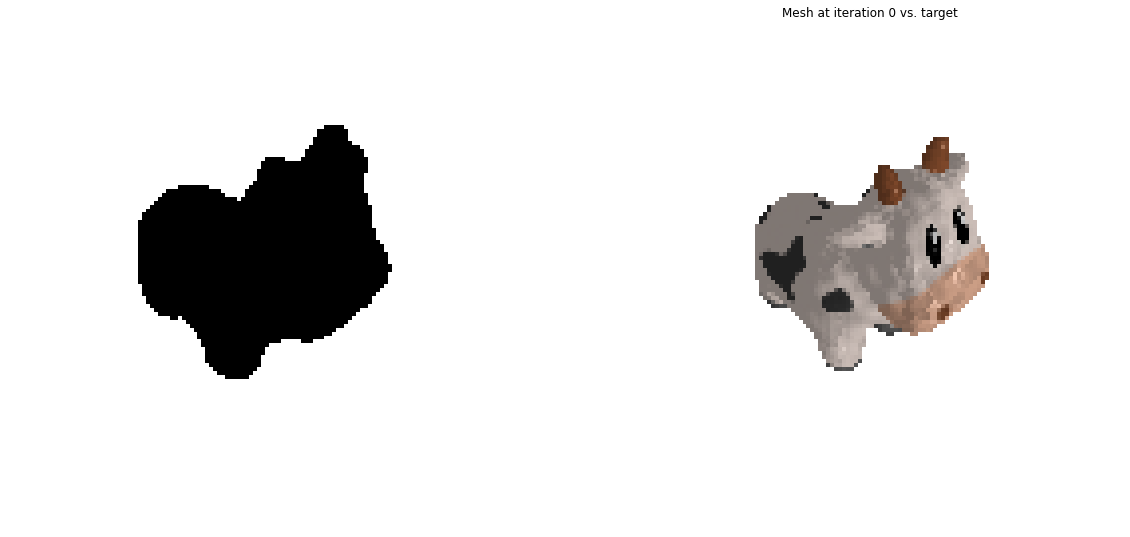

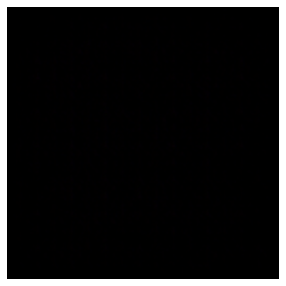

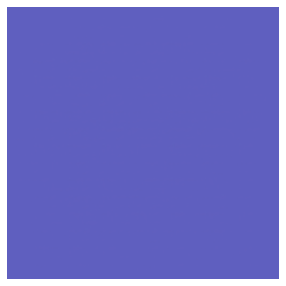

In [22]:

np.random.seed(random_seed)
map_size = 1024
num_meshes = 1
texture_size = (1, map_size, map_size, 3)
num_views = 20
imsize = 128

SHAPENET_PATH = "./data/ShapeNetsamples"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2, synsets=["04460130"])

# Get a batch of viewing angles. 
elev = np.random.permutation(torch.linspace(0, 360, num_views))
azim = np.random.permutation(torch.linspace(-180, 180, num_views))

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)
camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                T=T_novel) 

lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)


# Get a selection of random meshes to evaluate model with, can't use texture 
# atlas though so generate random textures using perlin noise
gen = torch.Generator(device='cuda') #for GPU acceleration
meshes=[]
for i in range(num_meshes):
    print("Generating mesh number {}".format(i), end="\r")
    meshes.append(load_shapenet_mesh(texture_size, gen, shapenet_dataset, random_seed))
print("Finished generating meshes")

DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
meshes[0]["mesh"] = load_objs_as_meshes([obj_filename], device=device)

for mesh in meshes:
    # Path to save results
    fig_path = os.path.join("./results", mesh["synset_id"], mesh["model_id"])
    if not os.path.isdir(fig_path):
        os.makedirs(fig_path)
    print("Predicting mesh")
    silhouette_result = mesh_prediction(mesh["mesh"], R, T, fig_path)
    print("Predicting mesh maps")

    model_verts, model_faces = silhouette_result.verts_packed(), silhouette_result.faces_packed()

    # Create UVs assuming equirectangular projection of sphere (very much approximation)
    xyz_to_u = torch.rad2deg(torch.arcsin(model_verts[:,2])) + 90
    xyz_to_u = xyz_to_u - torch.min(xyz_to_u)
    xyz_to_u = xyz_to_u / torch.max(xyz_to_u)

    xyz_to_v = (torch.rad2deg(torch.atan2(model_verts[:,1], model_verts[:,0])) + 180) / 2 
    xyz_to_v = xyz_to_v / torch.max(xyz_to_v)
    xyz_to_v = xyz_to_v - torch.min(xyz_to_v)
    sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1)

    silhouette_result.textures = TexturesUV(torch.ones(texture_size).to(device), model_faces.unsqueeze(0), sphere_verts_uvs.unsqueeze(0))
    silhouette_result.normalmaps = TexturesUV(torch.ones(texture_size).to(device), model_faces.unsqueeze(0), sphere_verts_uvs.unsqueeze(0))
    predicted_mesh = map_prediction(mesh["mesh"], silhouette_result, fig_path, R, T)


# fig = plt.figure(figsize=(10,5))
# ax1 = fig.add_subplot(122)
# ax1.set_axis_off()
# ax1.imshow(normal_map.squeeze())
# plt.plot()

In [ ]:
# imsize = 256
# # lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
# lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# # We arbitrarily choose one particular view that will be used to visualize 
# # results
# # Changed to novel view
# rand_elev = 45
# rand_azim = 135
# R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

# camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
#                                   T=T_novel) 


# # camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
# #                                   T=T[None, 1, ...]) 

# # Define the settings for rasterization and shading. Here we set the output 
# # image to be of size 128X128. As we are rendering images for visualization 
# # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# # rasterize_meshes.py for explanations of these parameters.  We also leave 
# # bin_size and max_faces_per_bin to their default values of None, which sets 
# # their values using heuristics and ensures that the faster coarse-to-fine 
# # rasterization method is used.  Refer to docs/notes/renderer.md for an 
# # explanation of the difference between naive and coarse-to-fine rasterization. 
# raster_settings = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=0.0, 
#     faces_per_pixel=1, 
#     perspective_correct=False,
# )

# # Create a Phong renderer by composing a rasterizer and a shader. The textured 
# # Phong shader will interpolate the texture uv coordinates for each vertex, 
# # sample from a texture image and apply the Phong lighting model
# mesh_to_render = predicted_mesh
# TBN_matrices = tbn_matrices(mesh_to_render)
# renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings
#     ),
#     shader=NormalSoftPhongShader(
#         device=device, 
#         cameras=camera,
#         lights=lights,
#         tangent_matrices=TBN_matrices,
#     )
# )
# with torch.no_grad():
#     random_target = renderer(mesh_to_render, cameras=camera, lights=lights)[...,:3]
# plt.imshow(random_target.cpu().numpy()[0])

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False, camera=target_cameras[0], target_image=target_rgb[0])
# plot_losses(losses)

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=maps_src_mesh.textures.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# # texture_image=new_src_mesh.normalmaps.maps_padded()

# texture_image=maps_src_mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

Save the final predicted mesh:

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(mesh.textures, subsample=None)
# # print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# # print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

## 4. Save the final predicted mesh

In [ ]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.